<a href="https://colab.research.google.com/github/jainkhere/cs480student/blob/main/06/CS480_Assignment_6_Kunal_Jain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

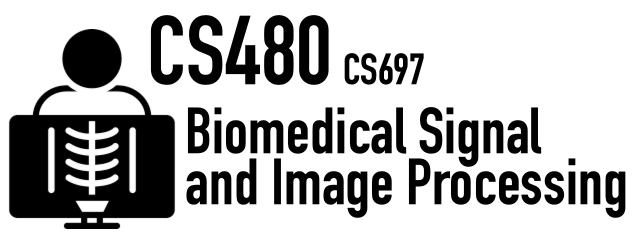
#Assignment 6

In [1]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [2]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [31]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-jukfwrbl
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-jukfwrbl


In [33]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [34]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [35]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [36]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [37]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER

# U-Net is trained to detect circles in a noisy image

In [38]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER

# Channels -> 
# Classes -> 2 classes, one for circle which is foreground and other for background.

In [39]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER

# Mitochondria is an organelle the power house of a cell. It appears like rounded or sausage like structure.

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [40]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [41]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('/content/drive/MyDrive/CS480/mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE
        image = tf.cast(image, tf.float32) / 255.0
        mask -= 1

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [50]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the bu

In [51]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER

# 70 percent of total images and mask are used for training. 
# 70 percent of 660 = 462 images and 462 masks

In [52]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [53]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [55]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            #
            # TODO: YOUR CODE
            #
            #
            train,
            val,
            epochs=50,
            batch_size=10
            )

Epoch 1/50
47/47 [==============================] - 32s 669ms/step - loss: 0.0370 - categorical_crossentropy: 0.0370 - categorical_accuracy: 0.9564 - mean_iou: 0.4579 - dice_coefficient: 0.9219 - auc_2: 0.9969 - learning_rate: 9.9911e-05 - val_loss: 0.0623 - val_categorical_crossentropy: 0.0623 - val_categorical_accuracy: 0.9429 - val_mean_iou: 0.4586 - val_dice_coefficient: 0.9196 - val_auc_2: 0.9956
Epoch 2/50
47/47 [==============================] - 32s 680ms/step - loss: 0.0455 - categorical_crossentropy: 0.0455 - categorical_accuracy: 0.9452 - mean_iou: 0.4538 - dice_coefficient: 0.9145 - auc_2: 0.9957 - learning_rate: 2.9991e-04 - val_loss: 0.0814 - val_categorical_crossentropy: 0.0814 - val_categorical_accuracy: 0.9210 - val_mean_iou: 0.4517 - val_dice_coefficient: 0.9054 - val_auc_2: 0.9928
Epoch 3/50
47/47 [==============================] - 32s 686ms/step - loss: 0.0509 - categorical_crossentropy: 0.0509 - categorical_accuracy: 0.9425 - mean_iou: 0.4515 - dice_coefficient: 0.9

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [56]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

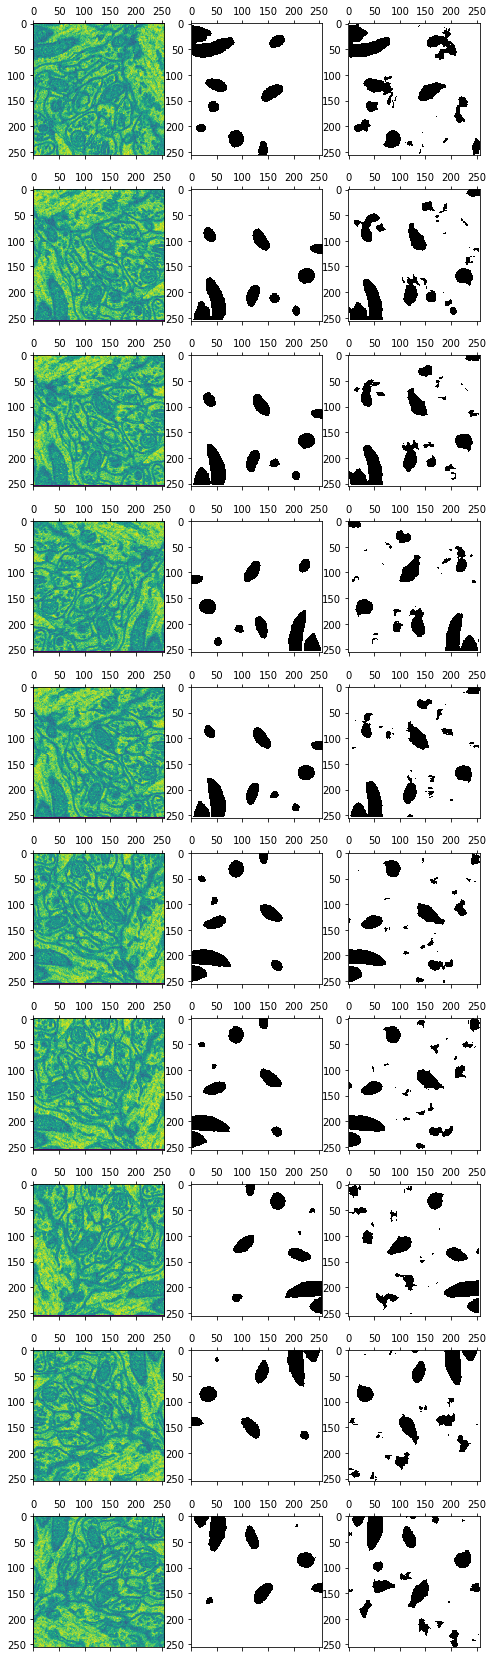

In [57]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [58]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER

In [59]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER
# The quality of segmentation is good but not best as there is some noise in segmented data.
# Maybe increasing batch size and epochs can help in improving quality of segmentation.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [60]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [61]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [62]:
# TODO: YOUR CODE

In [63]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv_block_18 (ConvBlock)      (None, None, None,   37568       ['inputs[0][0]']                 
                                64)                                                               
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, None, None,   0          ['conv_block_18[0][0]']          
                                64)                                                            

In [64]:
# Total parameters - 31,030,658
# Total trainable parameters - 31,030,658

In [65]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#
# Number of parameters used for encoders - 1,178,480
# Number of parameters used for decoders - 780,053

In [67]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [68]:
# TODO: YOUR ANSWER

# They reduced the number of convolutional filters throughout the network. They then replaced
# transpose convolutions in the decoder with light-weight bilinear upsampling layers that
# required no parameters. Lastly, they replaced center-cropping from the original U-Net with padding to output
# densely at full resolution. This modification increased the throughput by an additional 40%.

In [69]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [70]:
# TODO: YOUR ANSWER

# To make the segmentation process and to achieve segementation of Mitochondria in real time, 
# faster than currently available segmentation processes

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#